# Imports 

In [1]:
import librosa
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import matplotlib.pyplot as plt
import IPython.display as ipd
from glob import glob
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
from IPython.display import Audio


2024-03-12 00:33:29.367220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 00:33:29.367352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 00:33:29.534907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Optional Reading

Some of the most common feature extraction methods used in audio processing that we are going to use:

### MFCC (Mel-frequency cepstral coefficients):

- MFCCs are one of the most widely used feature extraction techniques in audio signal processing, particularly for speech recognition tasks.
- They capture the spectral envelope of an audio signal.
- The process involves applying the discrete cosine transform (DCT) to the log power spectrum of the audio signal.
- MFCCs are effective in capturing the characteristics of human speech due to their ability to approximate the human auditory system's response to sound frequencies.

### Mel Spectrogram:

- The Mel spectrogram is a visual representation of the power spectrum of an audio signal, where the frequencies are converted to the Mel scale.
- It divides the frequency spectrum into Mel-frequency bands, which are spaced according to human perception of sound.
- Mel spectrograms provide a compact representation of the frequency content of an audio signal and are often used as input for machine learning models in tasks such as music genre classification and audio event detection.

### Chroma Features:

- Chroma features capture the pitch content of an audio signal by representing the distribution of energy across different pitch classes (e.g., musical notes).
- They are useful for tasks involving harmonic analysis and music similarity.
- Chroma features are invariant to changes in timbre and loudness, making them suitable for tasks such as music genre classification and chord recognition.

### Spectral Contrast:

- Spectral contrast measures the difference in energy between peaks and valleys in the frequency spectrum of an audio signal.
- It provides information about the spectral texture or timbre of the audio signal.
- Spectral contrast features are useful for tasks such as music genre classification, audio fingerprinting, and sound texture analysis.
ound texture analysis.

# Exploration & Visualization

Let's take a note as an example to work on.

In [2]:
audio_files = glob('/kaggle/input/guitar-notes/Notes Datasets/*/*.wav')

In [3]:
ipd.Audio(audio_files[0])

In [4]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.06925214 -0.10363835 -0.09502773 -0.10533252 -0.10254002 -0.10822427
 -0.10330491 -0.10290752 -0.09605767 -0.09395082]
shape y: (10165,)
sr: 22050


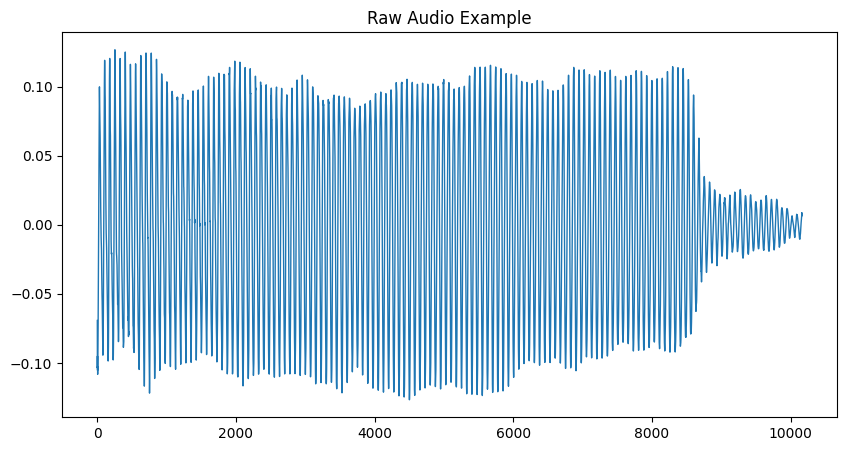

In [5]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

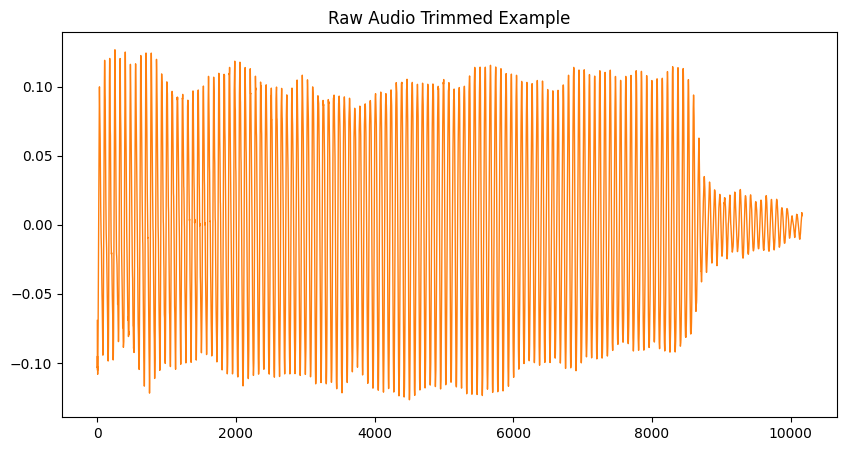

In [6]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

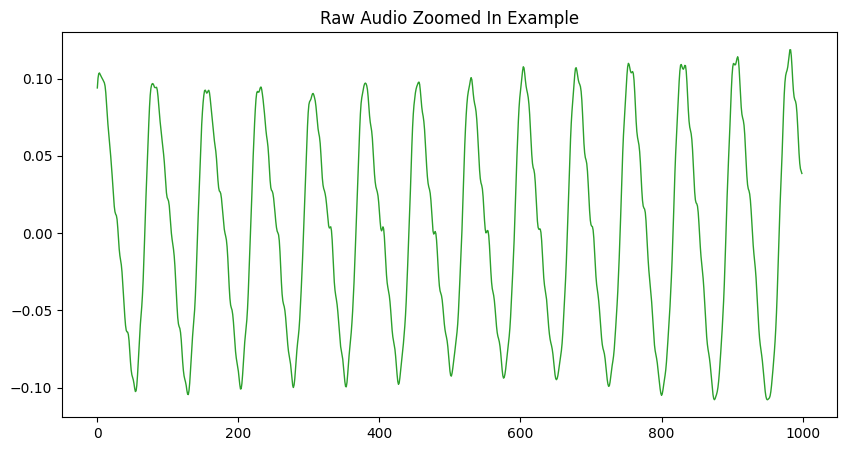

In [7]:
pd.Series(y[1000:2000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

## Visualizing the features extraction methods: 

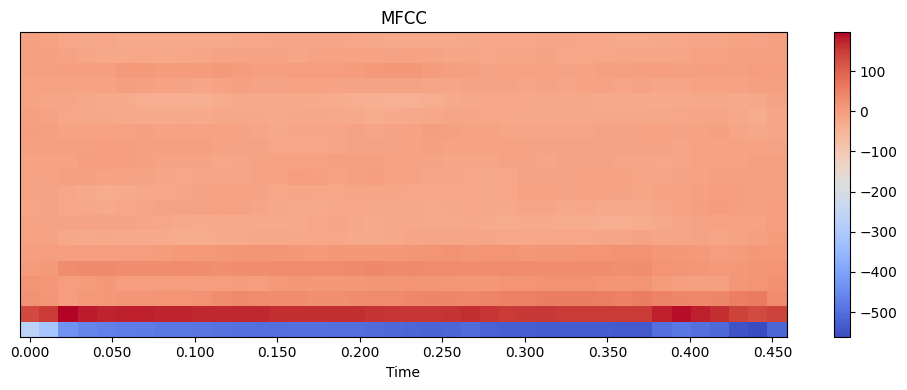

In [8]:
file_path = audio_files[0]
audio, sr = librosa.load(file_path, sr=None)

mfccs = librosa.feature.mfcc(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

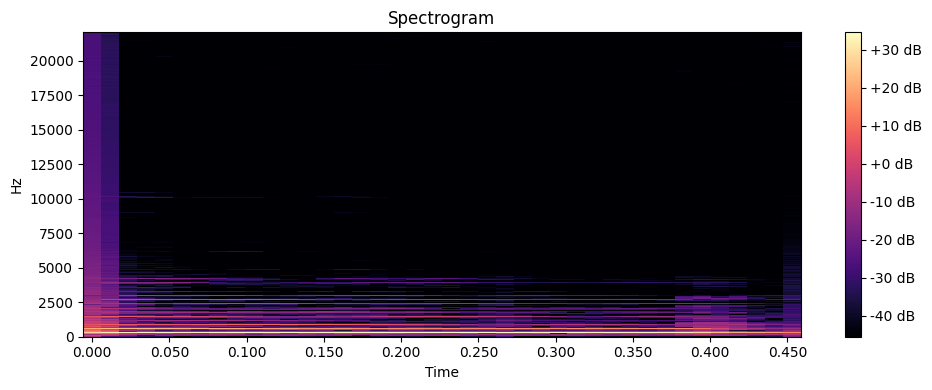

In [9]:
spectrogram = librosa.stft(audio)

spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

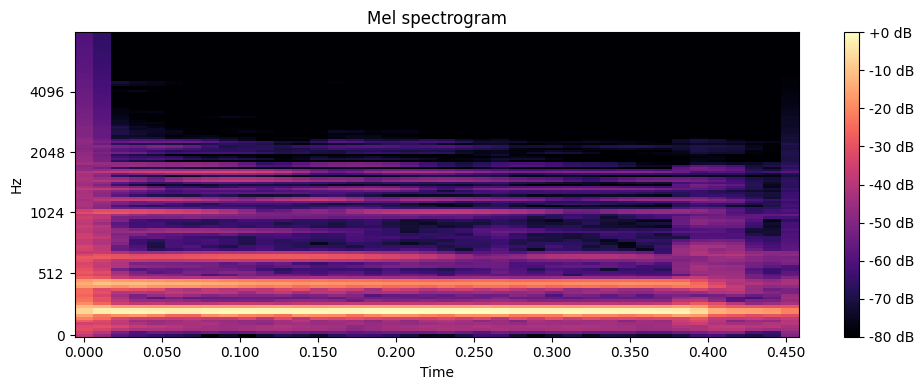

In [10]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sr, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

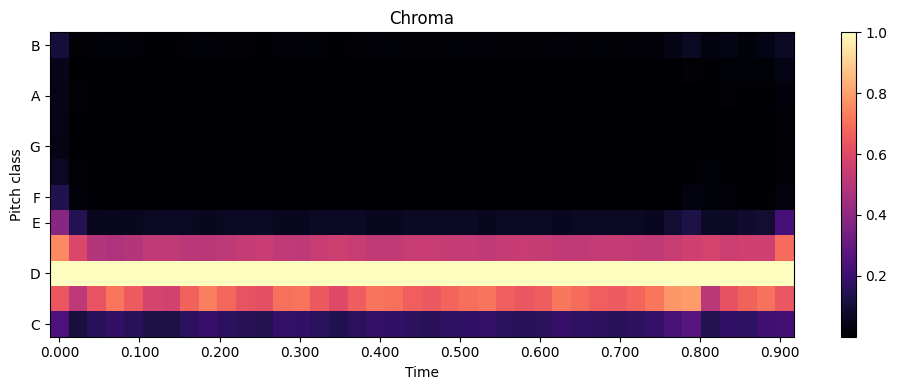

In [11]:
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.tight_layout()
plt.show()

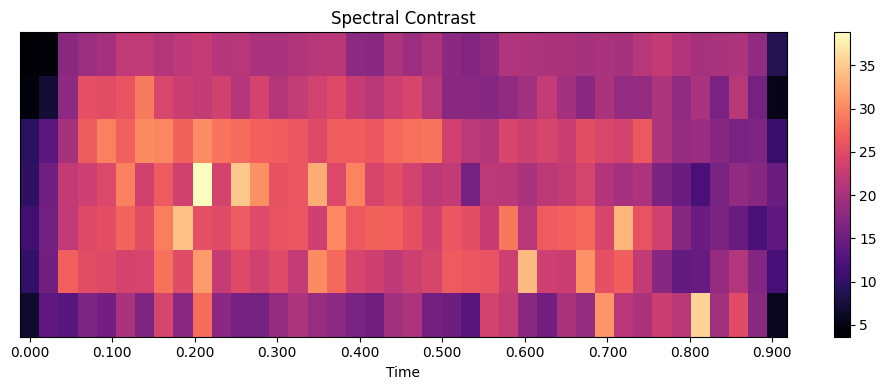

In [12]:
contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')
plt.tight_layout()
plt.show()

# Data Augmentation 

## Data Augmentation

Data augmentation enhances the diversity of training data by applying transformations. These techniques are valuable for audio tasks, improving model robustness and performance.

### Techniques:

1. **Add White Noise**: Introduce random noise to simulate real-world environments.

2. **Time Stretch**: Adjust duration without pitch alteration.

3. **Time Shift**: Vary timing for temporal robustness.

4. **Pitch Shift**: Simulate pitch changes for musical note variation.


In [13]:
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    
    return noisy_data


def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)


def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)


## Original audio

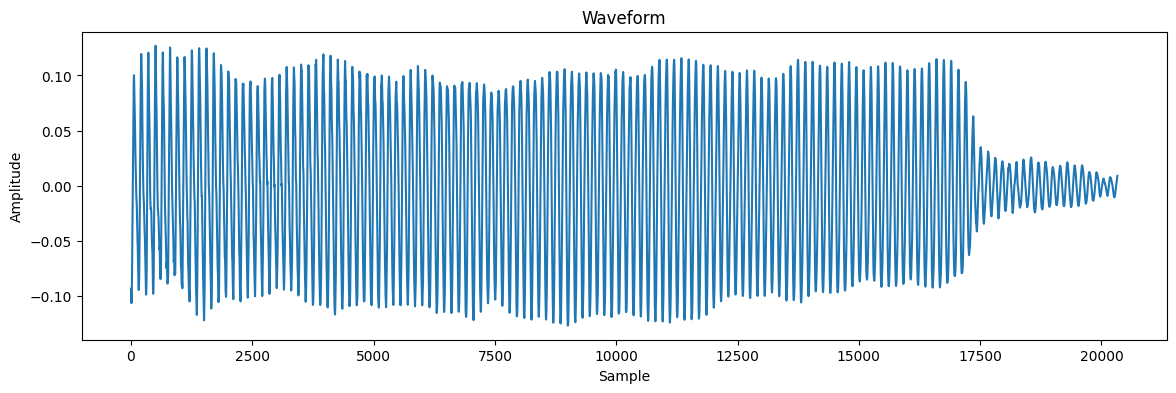

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(audio)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Audio(audio,rate=sr)

## Adding noise 

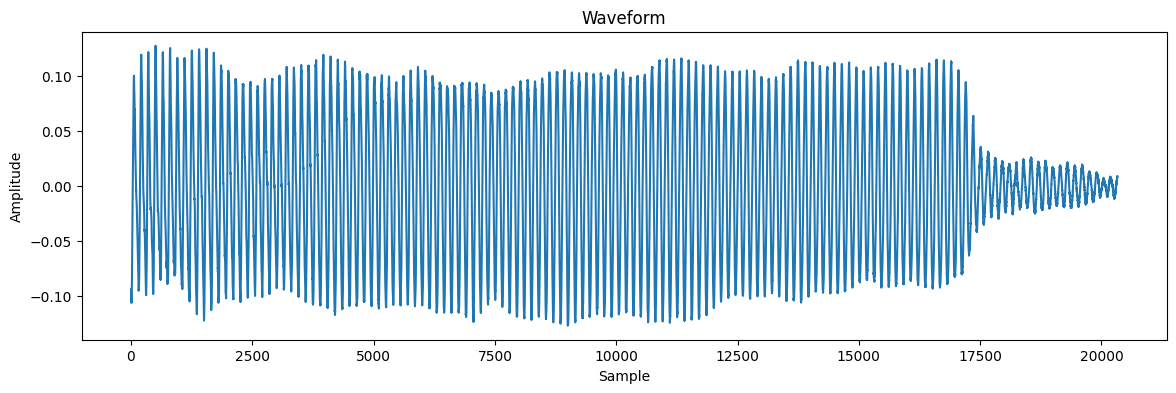

In [15]:
x = add_white_noise(audio)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sr)

## Adding time stretch 

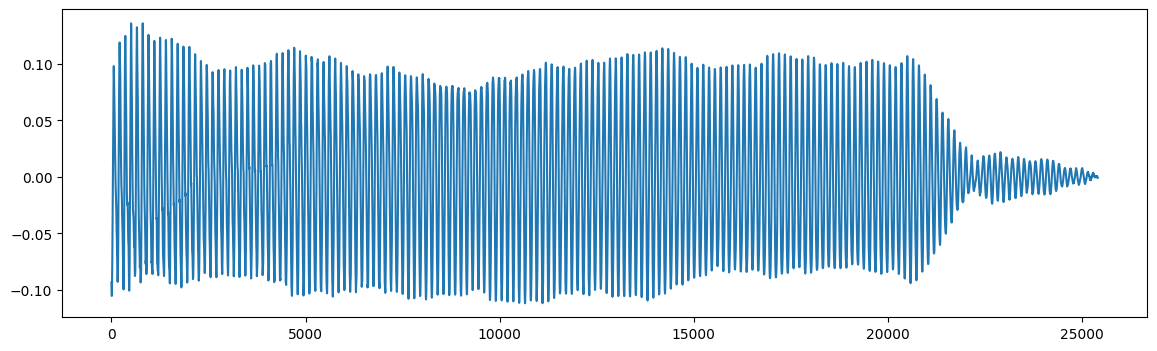

In [16]:
x = time_stretch(audio, rate=0.8)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.show()


Audio(x, rate=sr)

## Adding pitch shift 

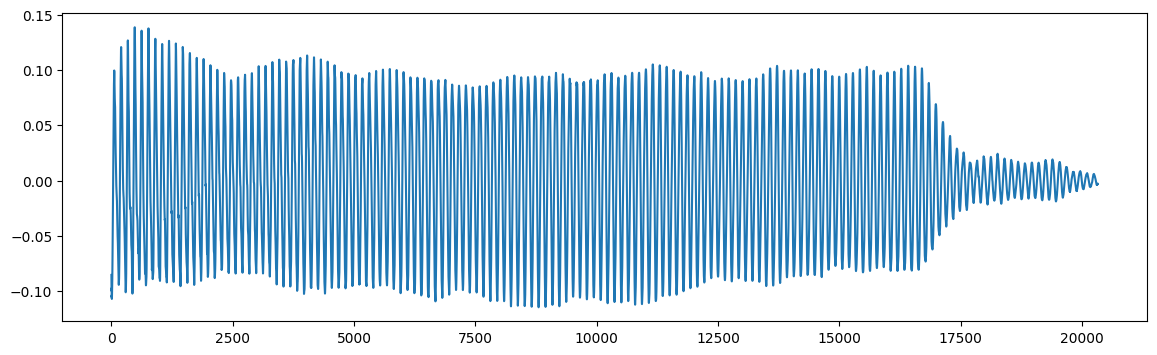

In [17]:
x = random_pitch_shift(audio, sr)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.show()
Audio(x, rate=sr)

# Preprocessing & Feature Extraction  

First, we need to define feature extraction function. We will use `MFCC`, `Mel Spectogram`,`Chroma` and `Spectral` features.

In [18]:
dataset_path = '/kaggle/input/guitar-notes/Notes Datasets'

def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)
    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label


# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    # Iterate through each audio file
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                # Extract MFCC features and label
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

data, labels = process_dataset(dataset_path)

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Converting the data from a list of arrays to a numpy array and flattening it, so that we can create a dataframe for the data.

In [19]:
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])

df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,15991,15992,15993,15994,15995,15996,15997,15998,15999,label
0,-438.792502,-478.009372,-562.837819,-569.717068,-573.072684,-570.423874,-561.689880,-557.779665,-552.760569,-545.857144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B2
1,-437.857613,-485.868336,-599.060510,-616.434108,-613.649018,-609.874655,-607.946813,-606.002685,-605.936747,-603.841032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C-sharp
2,-307.097691,-353.709941,-442.983741,-449.986192,-455.128116,-467.426085,-476.370647,-488.578168,-497.933726,-496.101606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G1
3,-370.115104,-402.488126,-492.950900,-502.344929,-504.976457,-505.917273,-506.720416,-500.151873,-488.920420,-468.317780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D1
4,-581.512843,-501.997389,-457.153579,-424.634953,-408.836787,-415.545106,-428.990734,-450.017774,-473.862567,-488.637408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,-292.757720,-335.272040,-444.218412,-440.359785,-419.710196,-398.977718,-374.307899,-362.818607,-365.507507,-368.112924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G-sharp 2
2266,-468.088223,-504.556080,-588.819909,-600.695241,-611.749989,-613.290147,-614.574125,-623.916717,-625.068881,-626.182420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D2
2267,-280.298667,-322.252365,-446.860416,-457.075146,-460.074833,-458.857894,-459.986006,-458.853146,-458.709561,-458.959448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E3
2268,-421.947147,-404.778306,-436.330454,-452.695689,-451.908216,-444.040153,-439.904849,-433.016892,-435.736592,-444.387529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F-sharp 1


# Splitting our data & Encoding the label

In [21]:
X = df.iloc[: ,:-1].values
Y = df['label'].values

In [22]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape


((1816, 16000), (1816, 37), (318, 16000), (318, 37), (136, 16000), (136, 37))

Applying `StandardScaler` to normalize our data. This means that the mean of each feature becomes zero, and the variance becomes one.

In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

Expanding the dimensions of the data so it is suitable for the neural network.

In [25]:
x_train = np.expand_dims(x_train, axis=-1)  # Add an extra dimension at the end
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

# Print the shapes to verify
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)


(1816, 16000, 1) (1816, 37) (318, 16000, 1) (318, 37) (136, 16000, 1) (136, 37)


# Modelling 

## CNN 

In [26]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(16000, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(37, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), verbose=1)

loss, accuracy = model.evaluate(x_val, y_val)

print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')


Epoch 1/50


I0000 00:00:1710203899.090161      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - 14s 235ms/step - loss: 3.9975 - accuracy: 0.0650 - val_loss: 3.0388 - val_accuracy: 0.4118
Epoch 2/50
29/29 [==============================] - 5s 188ms/step - loss: 2.8595 - accuracy: 0.2555 - val_loss: 2.1584 - val_accuracy: 0.6985
Epoch 3/50
29/29 [==============================] - 5s 188ms/step - loss: 1.9560 - accuracy: 0.4758 - val_loss: 1.0319 - val_accuracy: 0.8235
Epoch 4/50
29/29 [==============================] - 5s 188ms/step - loss: 1.4719 - accuracy: 0.6030 - val_loss: 0.6996 - val_accuracy: 0.8897
Epoch 5/50
29/29 [==============================] - 5s 189ms/step - loss: 1.0175 - accuracy: 0.7004 - val_loss: 0.4651 - val_accuracy: 0.9265
Epoch 6/50
29/29 [==============================] - 5s 189ms/step - loss: 0.9104 - accuracy: 0.7494 - val_loss: 0.3305 - val_accuracy: 0.9265
Epoch 7/50
29/29 [==============================] - 5s 190ms/step - loss: 0.7095 - accuracy: 0.7830 - val_loss: 0.2305 - val_accuracy: 0.9265
Epoch 8/50
29/29

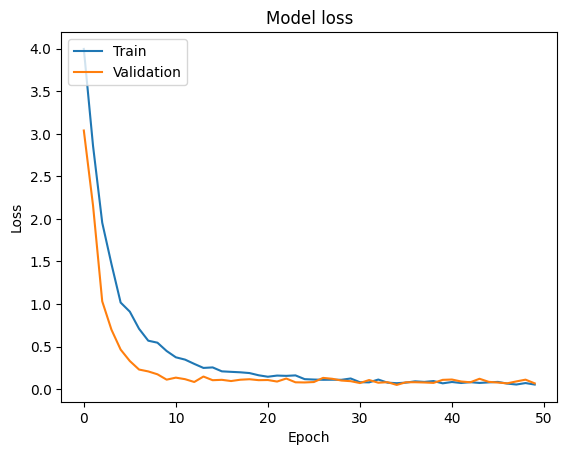

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

10/10 [==============================] - 1s 101ms/step
Test Accuracy: 0.962


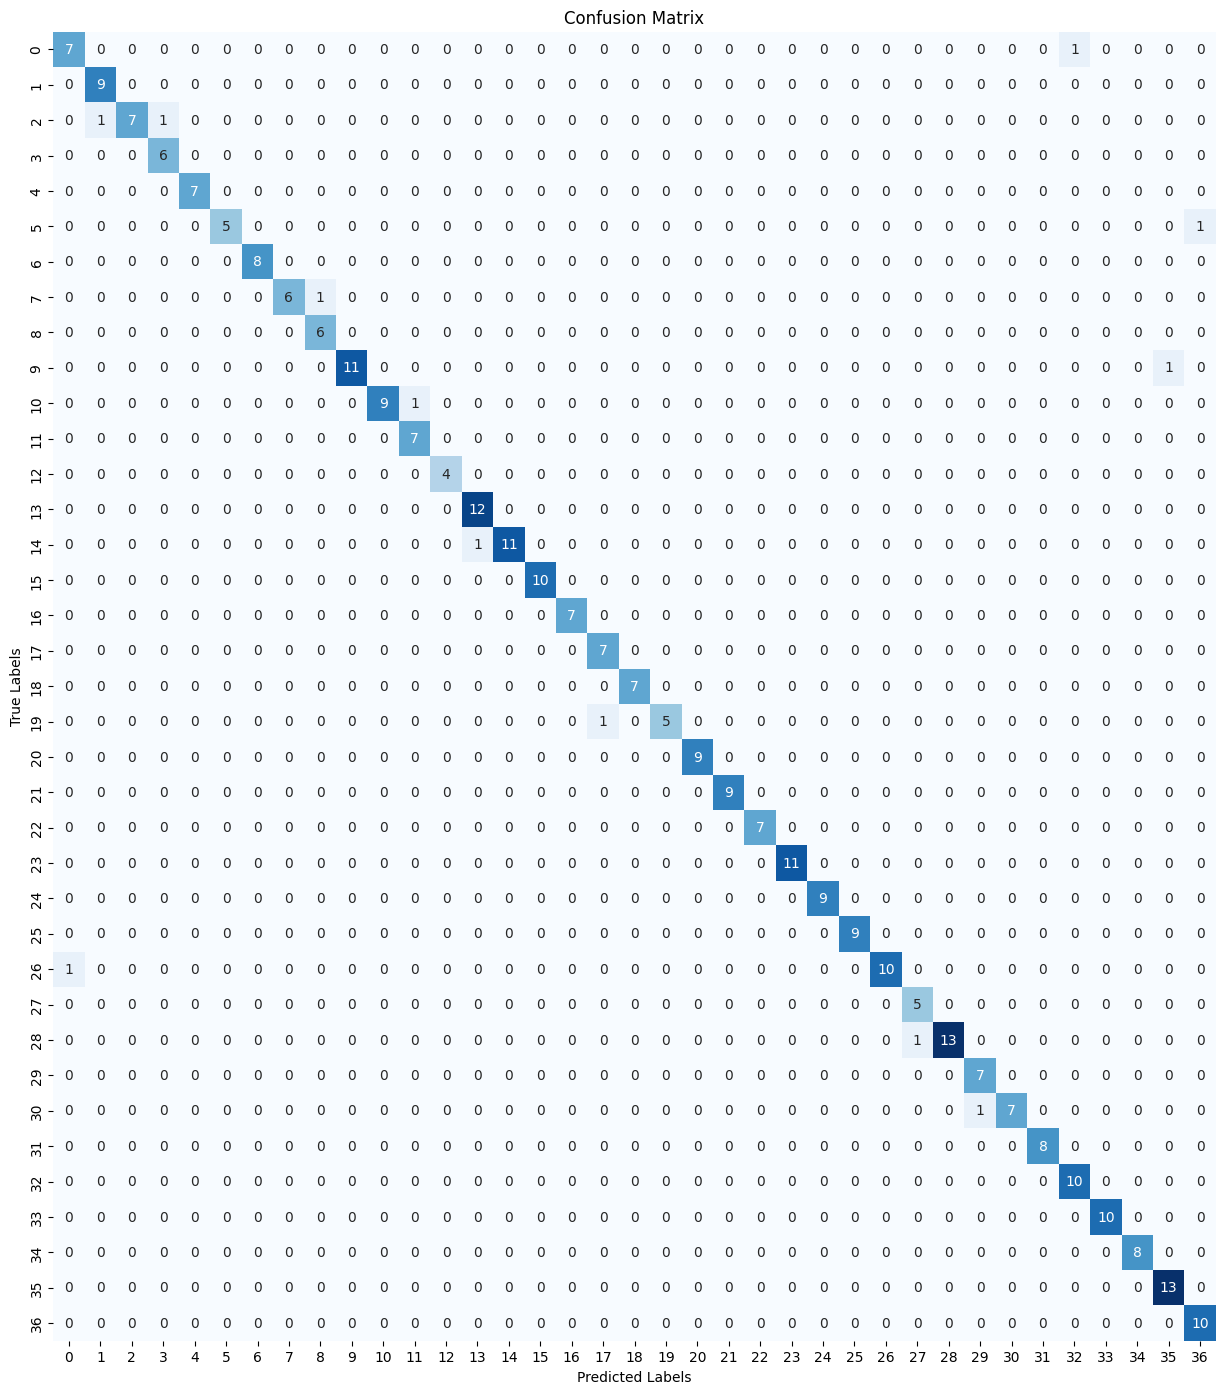

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

predictions = model.predict(x_test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test Accuracy: {accuracy:.3f}')

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Examples

1/1 [==============================] - 0s 271ms/step


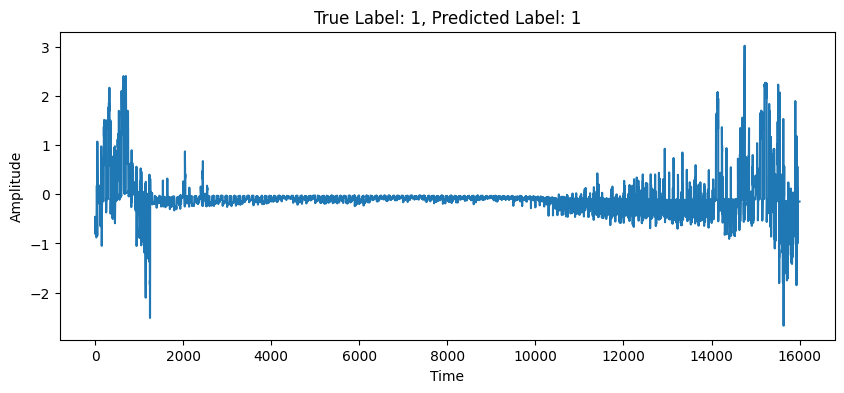

In [29]:
sample_index = 124 
sample = x_test[sample_index]
true_label = np.argmax(y_test[sample_index])

predicted_probs = model.predict(sample.reshape(1, -1, 1))[0]
predicted_label = np.argmax(predicted_probs)

plt.figure(figsize=(10, 4))
plt.plot(sample)
plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


1/1 [==============================] - 0s 19ms/step


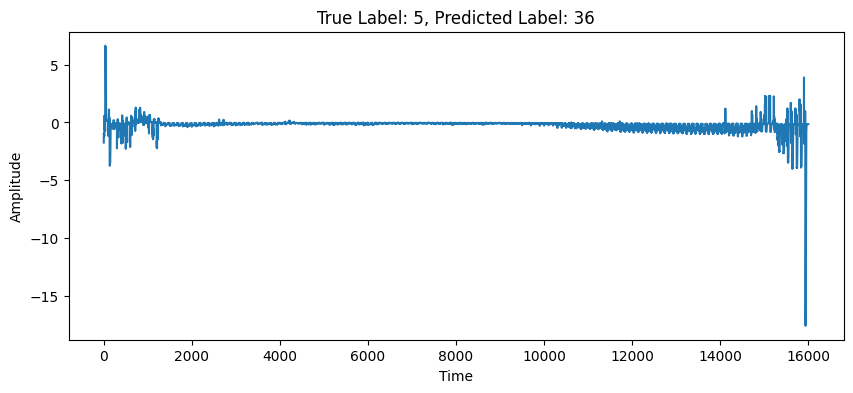

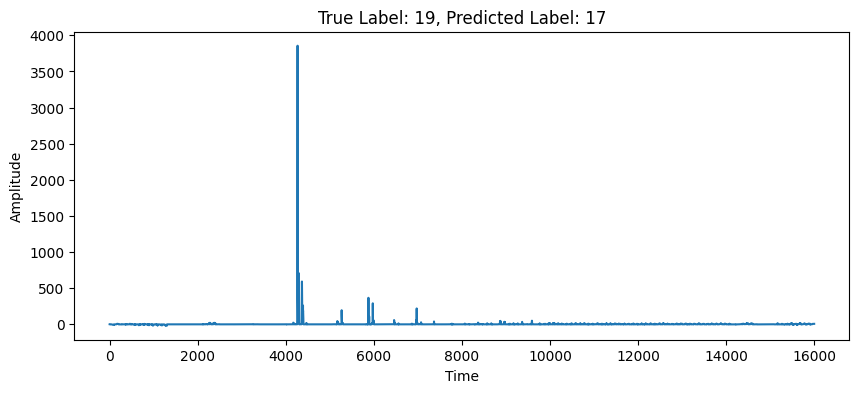

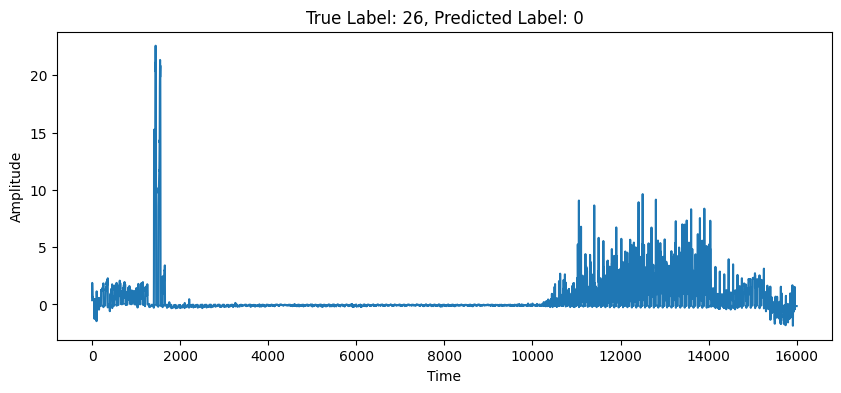

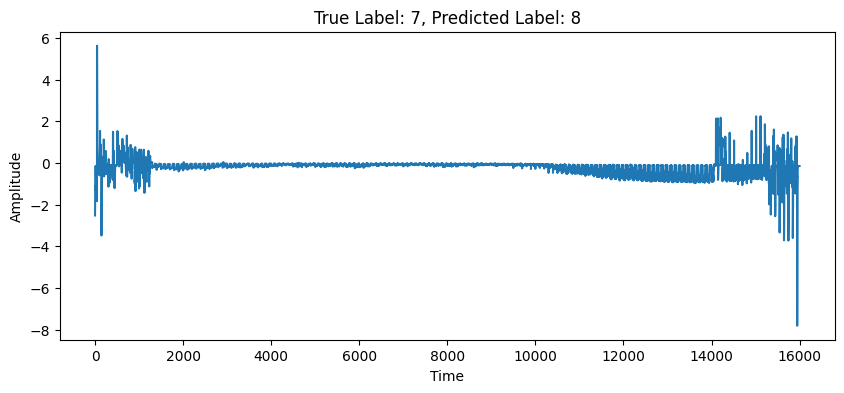

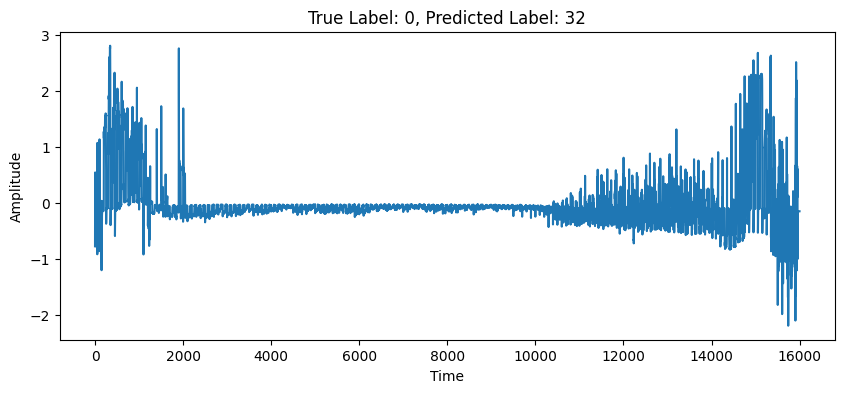

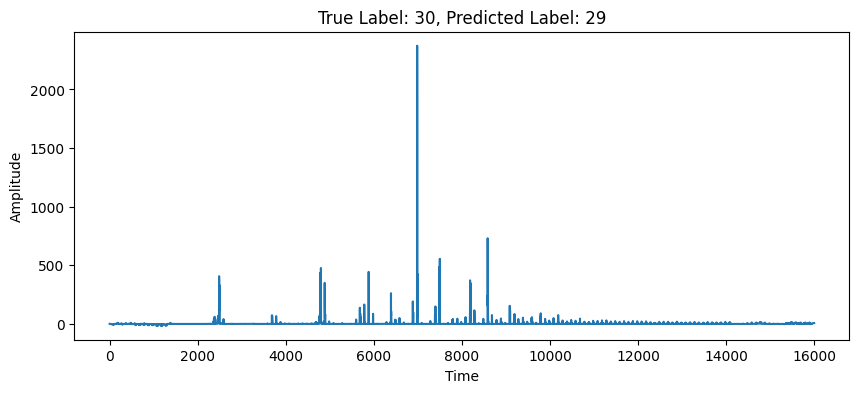

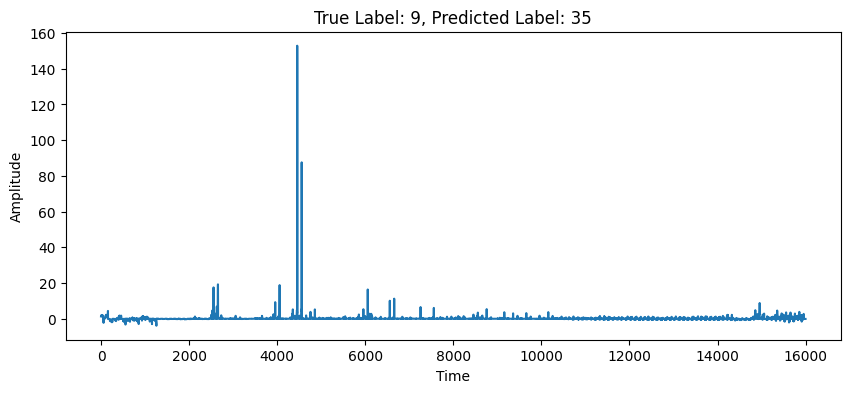

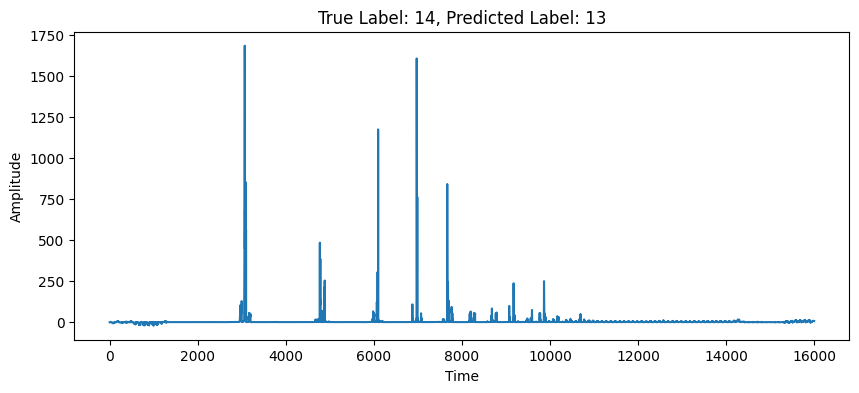

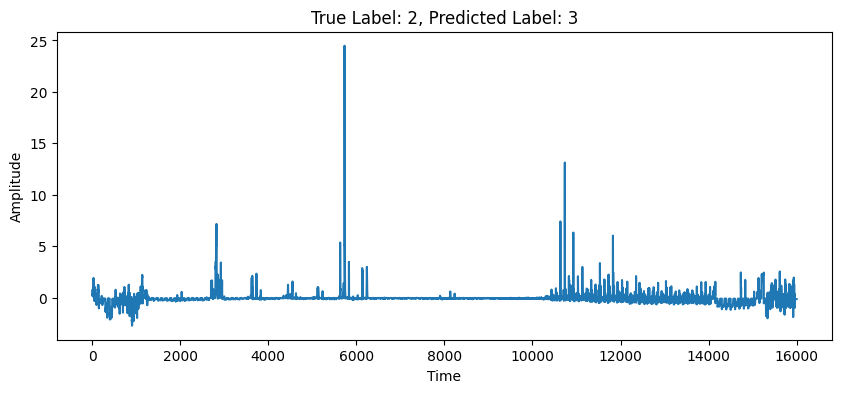

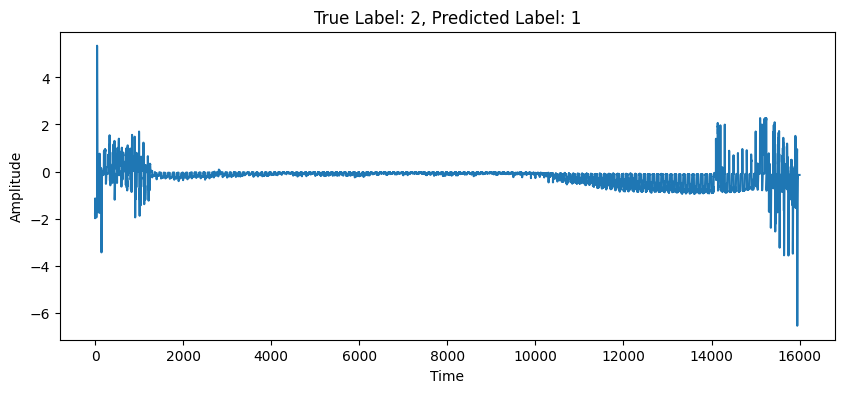

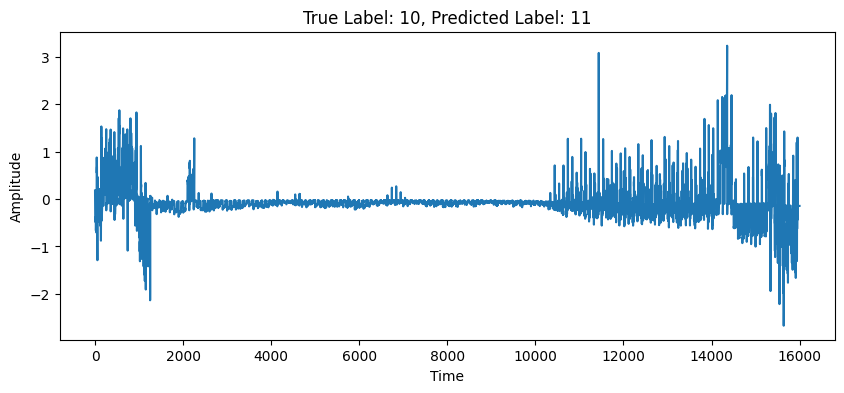

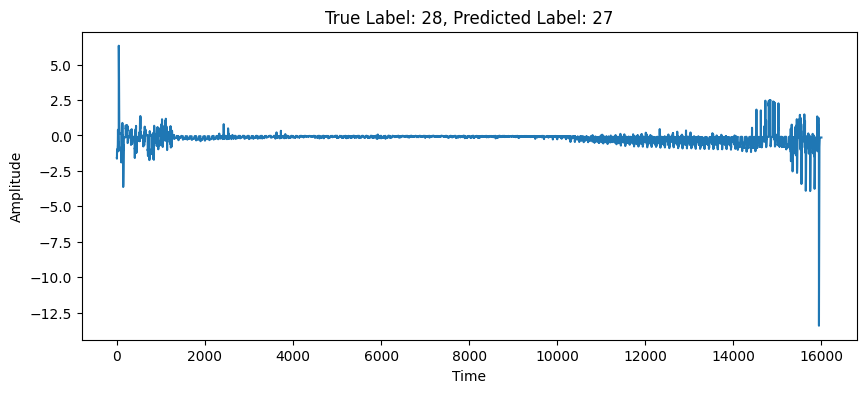

In [30]:
incorrect_indices = []
incorrect_predictions = []

for i in range(len(x_test)):
    sample = x_test[i]
    true_label = np.argmax(y_test[i])
    
    predicted_probs = model.predict(sample.reshape(1, -1, 1))[0]
    predicted_label = np.argmax(predicted_probs)
    
    if predicted_label != true_label:
        incorrect_indices.append(i)
        incorrect_predictions.append((sample, true_label, predicted_label))

for sample, true_label, predicted_label in incorrect_predictions:
    plt.figure(figsize=(10, 4))
    plt.plot(sample)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
